In [1]:
import tensorflow as tf

# TensorFlow 버전 확인
print("TensorFlow version:", tf.__version__)

# GPU 사용 가능 여부 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import sys

BASE_DIR = os.path.dirname(os.path.abspath(os.path.abspath('')))
WORK_DIR = os.path.join(BASE_DIR, 'code')
sys.path.append(WORK_DIR)
print('base dir: ', BASE_DIR)

base dir:  c:\Users\user1\Desktop\BONBID Project


In [4]:
import tensorflow as tf
import numpy as np
import random
import os

# 난수 시드 설정
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 첫 번째 GPU 사용 ("0", "1" 등으로 설정 가능)

# GPU 메모리 자동 증가 설정 (필요한 만큼 메모리 할당)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU 메모리 자동 증가 설정 완료")
    except RuntimeError as e:
        print(e)
else:
    print("GPU를 찾을 수 없습니다.")

GPU 메모리 자동 증가 설정 완료


In [5]:
# 데이터 경로 설정
TRAIN_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/train/converted/1ADC_ss')
TRAIN_Z_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/train/converted/2Z_ADC')
TRAIN_LABEL_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/train/converted/3LABEL')

VAL_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/val/converted/1ADC_ss')
VAL_Z_ADC_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/val/converted/2Z_ADC')
VAL_LABEL_CONVERTED_PATH = os.path.join(BASE_DIR, 'data/val/converted/3LABEL')

# output_dir = os.path.join(BASE_DIR, 'data/train/processed')
# model_save_dir = os.path.join(project_base_dir, 'small_data/models')

# 모델 저장 디렉토리가 존재하지 않으면 생성
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 256, 6  0           []                               
                                4, 2)]                                                            
                                                                                                  
 conv3d_95 (Conv3D)             (None, 256, 256, 64  880         ['image[0][0]']                  
                                , 16)                                                             
                                                                                                  
 batch_normalization_90 (BatchN  (None, 256, 256, 64  64         ['conv3d_95[0][0]']              
 ormalization)                  , 16)                                                       

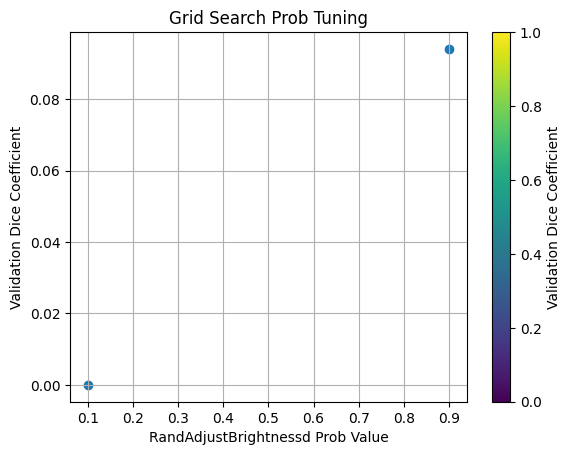

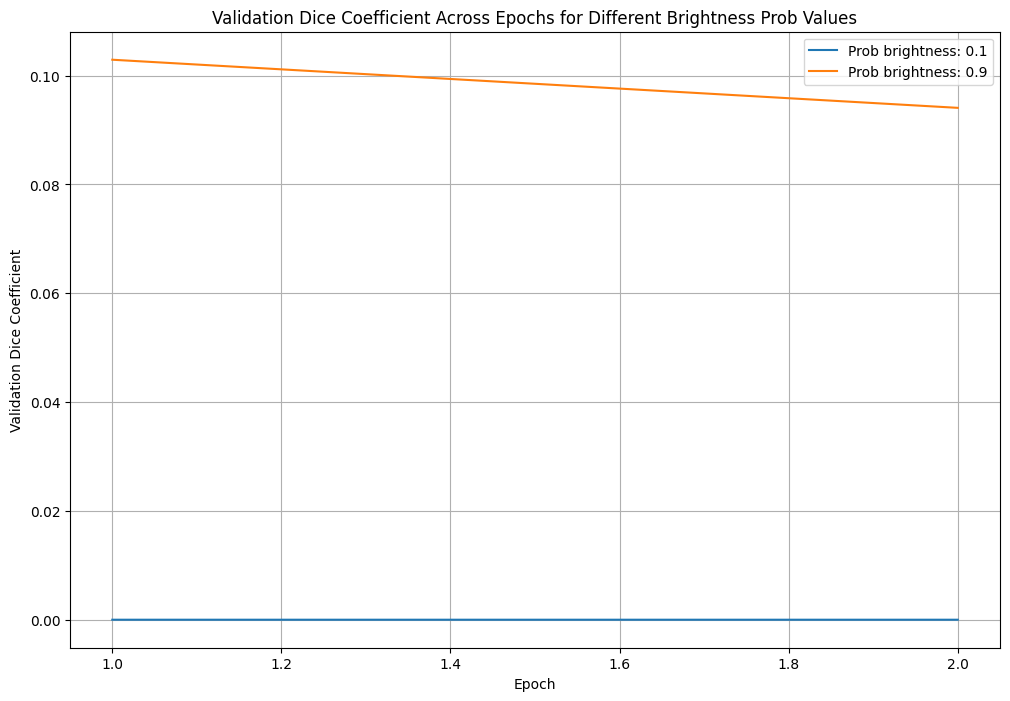

Best Parameters: {'prob_brightness': 0.9}
Best Validation Score: 0.09407864511013031


In [9]:
# Grid Search
import sys
from preprocessing import *
from Model import *
from monai.data import DataLoader
import tensorflow as tf
from preprocessing import convert_monai_to_tf_dataset

train_data_path = create_combined_path(
    TRAIN_ADC_CONVERTED_PATH,
    TRAIN_Z_ADC_CONVERTED_PATH,
    TRAIN_LABEL_CONVERTED_PATH
)

val_data_path = create_combined_path(
    VAL_ADC_CONVERTED_PATH,
    VAL_Z_ADC_CONVERTED_PATH,
    VAL_LABEL_CONVERTED_PATH,
)

unet_model = Unet3DModel(img_height=256, img_width=256, img_depth=64, img_channels=2)

param_grid = {
    'prob_brightness': np.linspace(0.1, 0.9, 9)
    # 'prob_elastic': np.linspace(0.1, 0.9, 9)
}

# 밝기 증강만 적용
best_params, best_score = unet_model.grid_search_prob_tuning(train_data_path, val_data_path, param_grid, epochs=100, augmentations='brightness')


# elastic 증강만 적용
# param_grid_elastic = {
#     'prob_elastic': np.linspace(0.1, 0.9, 9)
# }
# best_params, best_score = unet_model.grid_search_prob_tuning(train_data_path, val_data_path, param_grid_elastic, epochs=100, augmentations='elastic')

# 둘 다 적용
# param_grid_both = {
#     'prob_brightness': np.linspace(0.1, 0.9, 9),
#     'prob_elastic': np.linspace(0.1, 0.9, 9)
# }
# best_params, best_score = unet_model.grid_search_prob_tuning(train_data_path, val_data_path, param_grid_both, epochs=100, augmentations='both')



print(f"Best Parameters: {best_params}")
print(f"Best Validation Score: {best_score}")

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
import numpy as np
from tensorflow.keras.models import load_model
from Model import DiceLoss, DiceCoefficient

# 저장된 모델 로드
model = load_model('/content/drive/MyDrive/Colab Notebooks/BONBID Project/models/best_dice_model.keras', custom_objects={'MeanIoU': MeanIoU, 'DiceCoefficient': DiceCoefficient, 'DiceLoss': DiceLoss})

# 모델 평가
def evaluate_model(model, val_tf_dataloader):
    results = model.evaluate(val_tf_dataloader)
    print(f"Validation Loss: {results[0]}")
    print(f"Validation Accuracy: {results[1]}")
    print(f"Mean IoU: {results[2]}")
    print(f"Dice Coefficient: {results[3]}")

evaluate_model(model, val_tf_dataloader)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, val_tf_dataloader, num_samples=4):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    for i, (data, label) in enumerate(val_tf_dataloader.take(num_samples)):
        prediction = model.predict(data)
        image = data.numpy().squeeze()
        label = label.numpy().squeeze()
        prediction = prediction.squeeze()

        # 이진화 과정 추가
        threshold = 0.5
        prediction_binary = (prediction >= threshold).astype(np.float32)

        slice_idx = image.shape[2] // 2  # 중앙 슬라이스 선택

        # 첫 번째 채널의 입력 이미지 시각화
        axes[i, 0].imshow(image[:, :, slice_idx, 0], cmap='gray')
        axes[i, 0].set_title('Input Image - Channel 1')
        axes[i, 0].axis('off')

        # 두 번째 채널의 입력 이미지 시각화
        axes[i, 1].imshow(image[:, :, slice_idx, 1], cmap='gray')
        axes[i, 1].set_title('Input Image - Channel 2')
        axes[i, 1].axis('off')

        # 실제 마스크 시각화
        axes[i, 2].imshow(label[:, :, slice_idx], cmap='gray')
        axes[i, 2].set_title('True Mask')
        axes[i, 2].axis('off')

        # 예측된 마스크 시각화
        axes[i, 3].imshow(prediction_binary[:, :, slice_idx], cmap='gray')
        axes[i, 3].set_title('Predicted Mask')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_tf_dataloader, num_samples=4)